# Assortative Matching With Coarse Types: Chi-Square Estimator of Deep Parameters given Stochastic Classification of Economics Departments by Placement Rates

James Yu, 18 November 2021

In [1]:
INSTALL_PACKAGES = false   # change this to true if you are running this notebook for the first time
YEAR_INTERVAL = 2015:2020  # change this to select the years of data to include in the estimation
NUMBER_OF_TYPES = 4        # change this to select the number of types to classify academic departments into
NUMBER_OF_SINKS = 1        # change this to 4 to use individual sink types
TOTAL_DISTRIBUTIONS = NUMBER_OF_TYPES + NUMBER_OF_SINKS;

In [2]:
import Pkg
for package in ["BlackBoxOptim", "Distributions", "ForwardDiff", "JSON", "Optim", "Quadrature", "StatsPlots"]
    if INSTALL_PACKAGES
        Pkg.add(package)
    end
end
using BlackBoxOptim, Distributions, ForwardDiff, JSON, Optim, Quadrature, StatsPlots

There are two components to this notebook. The first is an algorithm for classifying Economics departments into a series of types based on placement outcome data.

The placement data used is grouped as a dictionary of applicants sorted by year of starting application. In total, the data spans from 2003 to 2021. The procedure for compiling the data is provided in a separate Python file.

In [3]:
year_by_year = JSON.parsefile("to_from_by_year.json")
print(sort(collect(keys(year_by_year))))

["2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021"]

For our estimation, we will only consider placements from 2015 to 2020 as the number of reported graduates on EconJobMarket was the most stable and even over this period. We put all placement outcomes for Assistant Professor positions in one set, and all other placement outcomes in another set. The other placement outcomes are those where applicants were hired at departments that do not graduate Ph.D. students; this includes the public sector, private sector, government, non-academic positions at academic departments and teaching universities, among others.

In [4]:
i = 0

academic_builder = Set{}()
sink_builder = Set{}()

for key in YEAR_INTERVAL
    data = year_by_year[string(key)]
    println(key, " has ", length(keys(data)), " entries")
    for aid in keys(data)
        outcome = data[aid]
        if outcome["position_name"] == "Assistant Professor"
            push!(academic_builder, outcome)
        else
            push!(sink_builder, outcome)
        end
    end
end
println(length(academic_builder), " total assistant professor outcomes")
println(length(sink_builder), " other outcomes")

2015 has 512 entries
2016 has 1145 entries
2017 has 837 entries
2018 has 912 entries
2019 has 1002 entries
2020 has 847 entries
3608 total assistant professor outcomes
1647 other outcomes


This piece of code deals with teaching universities by checking if they ever graduated Ph.D. students:

In [5]:
academic = Set{}()
academic_to = Set{}()
for outcome in academic_builder
    push!(academic, outcome["from_institution_name"])
    push!(academic_to, outcome["to_name"])
end

tch_sink = Set{}() # sink of teaching universities that do not graduate PhDs
for key in academic_to
    if !(key in academic)
        push!(tch_sink, key)
    end
end

println(length(academic))
println(length(academic_to))
println(length(tch_sink))

361
801
494


The next piece of code sorts all the sink departments (except teaching universities, which are dealt with above) by category:

In [6]:
filter_sink_builder = Set{}()
for outcome in sink_builder
    if outcome["from_institution_name"] in academic
        push!(filter_sink_builder, outcome)
    end
end

acd_sink = Set{}()
gov_sink = Set{}()
pri_sink = Set{}()

for outcome in filter_sink_builder
    # CODE global academic, other_placements, pri_sink, gov_sink, acd_sink
    if outcome["recruiter_type"] in [6, 7]
        # private sector: for and not for profit
        push!(pri_sink, string(outcome["to_name"], " (private sector)"))
    elseif outcome["recruiter_type"] == 5
        # government institution
        push!(gov_sink, string(outcome["to_name"], " (public sector)"))
    else
        # everything else including terminal academic positions
        push!(acd_sink, string(outcome["to_name"], " (academic sink)"))
    end
end

println(length(acd_sink))
println(length(gov_sink))
println(length(pri_sink))

205
91
102


Now that we have five sets for every category of department, we can construct a matrix representing the placements between these departments:

In [7]:
institutions = vcat(collect(academic), collect(acd_sink), collect(gov_sink), collect(pri_sink), collect(tch_sink))

out = zeros(Int64, length(institutions), length(collect(academic)))
i = 0
for outcome in academic_builder
    i += 1
    out[findfirst(isequal(outcome["to_name"]), institutions), findfirst(isequal(outcome["from_institution_name"]), institutions)] += 1
end
for outcome in filter_sink_builder
    i += 1
    keycheck = ""
    if outcome["recruiter_type"] in [6, 7]
        keycheck = string(outcome["to_name"], " (private sector)")
    elseif outcome["recruiter_type"] == 5
        keycheck = string(outcome["to_name"], " (public sector)")
    else
        keycheck = string(outcome["to_name"], " (academic sink)")
    end
    out[findfirst(isequal(keycheck), institutions), findfirst(isequal(outcome["from_institution_name"]), institutions)] += 1
end
println("Total number of outcomes: ", i)

Total number of outcomes: 5156


Finally, we get to the estimator. For this estimate, we assume that each observed set of placement outcomes between any two pairs of departments is drawn from a distribution common to the "type" of the hiring department and the "type" of the graduating department. Here this distribution is assumed to be Poisson, in line with classical stochastic block models used for similar estimations in Karrer and Newman (2011) and Peixoto (2014).

Given a particular assignment of departments to types, and given the placement outcomes, a single round of estimation computes the mean number of applicants from any single type $t$ department that would be hired at a single type $t^\prime$ department and measures the probability that each independent observation was drawn from its corresponding mean. When summed together, the logarithms of the probabilities form a log-likelihood which can be used for maximum likelihood estimation.

In [8]:
function bucket_estimate(assign::Array{Int64}, A::Matrix{Int64}, num, numsink)
    b = zeros(Int64, size(A)[1], size(A)[2])
    T = zeros(Int64, num + numsink, num)
    count = zeros(num + numsink, num)
    for i in 1:size(A)[1], j in 1:size(A)[2]
         @inbounds val = (num + 1) * (assign[j] - 1) + assign[i]
         @inbounds b[i, j] = val
         @inbounds T[val] += A[i, j]
         @inbounds count[val] += 1
    end
    L = 0.0
    @simd for i in eachindex(A)
        @inbounds L += logpdf(Poisson(T[b[i]]), A[i])
    end
    return -L, T
end

bucket_estimate (generic function with 1 method)

Finally, we compute the maximum-likelihood estimated Poisson means by stochastically re-allocating departments to types and saving likelihood-improving re-allocations until no further re-allocations are found.

In [9]:
function doit(sample, academic_institutions, asink, gsink, psink, tsink, all_institutions, num, numsink)
    # some initial states
    current_allocation = Array{Int64}(undef, length(all_institutions))
    cur_objective = Inf
    best_mat = nothing
    cursor = 1
    for inst in academic_institutions
        current_allocation[cursor] = rand(1:num)
        cursor += 1
    end
    # the sinks must stay in fixed types
    # this was built to support more sinks, but by default we only use one
    # change the "current_allocation[cursor] = ..." lines to group sinks together
    for key in asink # other academic
        current_allocation[cursor] = num + min(1, numsink)
        cursor += 1
    end
    for key in gsink # public sector
        current_allocation[cursor] = num + min(2, numsink)
        cursor += 1
    end
    for key in psink # private sector
        current_allocation[cursor] = num + min(3, numsink)
        cursor += 1
    end
    for key in tsink # assistant professor at teaching universities
        current_allocation[cursor] = num + min(4, numsink)
        cursor += 1
    end
    blankcount = 0

    # BEGIN MONTE CARLO REALLOCATION ROUTINE
    while true
        # attempt to reallocate between 1 and 3 academic institutions to a random spot
        temp_allocation = copy(current_allocation)
        @simd for k in rand(1:length(academic_institutions), rand(1:3))
            @inbounds temp_allocation[k] = rand(delete!(Set(1:num), temp_allocation[k]))
        end
        # check if the new assignment is better
        test_objective, estimated_means = bucket_estimate(temp_allocation, sample, num, numsink)
        if test_objective < cur_objective
            print(test_objective, " ")
            blankcount = 0
            cur_objective = test_objective
            best_mat = estimated_means
            current_allocation = temp_allocation
        else
            blankcount += 1
            if blankcount % 1000 == 0
                print(blankcount, " ")
            end
        end
        if blankcount == 30000
            return cur_objective, best_mat, current_allocation
        end
    end
end

est_obj, est_mat, est_alloc = doit(out, collect(academic), collect(acd_sink), collect(gov_sink), collect(pri_sink), collect(tch_sink), institutions, NUMBER_OF_TYPES, NUMBER_OF_SINKS)

2.4147558050692806e8 2.4134577445052275e8 2.409592544249184e8 2.4056873256234425e8 2.4039006167378575e8 2.4029714988725418e8 2.3992249048864612e8 2.398940754546533e8 2.394978607220628e8 2.3902739377272475e8 2.3884349410398373e8 2.385031868169724e8 2.3848962876257944e8 2.3816412805677357e8 2.3780671743987134e8 2.3773999638178962e8 2.3744958418896076e8 2.3702744062397635e8 2.3702273623971882e8 2.368819065048253e8 2.366999786110278e8 2.3636600060062537e8 2.3612281427159834e8 2.360795753343701e8 2.3606619860632038e8 2.3578978037292725e8 2.3575251451215076e8 2.3564749931844828e8 2.3559974938223338e8 2.355532001647057e8 2.354779062402364e8 2.3537976516938233e8 2.3477330615391827e8 2.3403341264418966e8 2.3363520101634747e8 2.3343570564401296e8 2.3334369788805914e8 2.333233621744734e8 2.3265447186179572e8 2.3219443904161316e8 2.3203889790390202e8 2.319670588737648e8 2.3156502616630316e8 2.314985675121164e8 2.3127118322846717e8 2.312135040849085e8 2.3056260323620275e8 2.3052683663513005e8 2.301

(1.5283596816053194e8, [115 178 41 354; 71 165 21 329; … ; 34 79 11 445; 432 751 166 1375], [4, 3, 1, 1, 3, 2, 3, 2, 1, 3  …  5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

The resulting allocation of departments to types can be found at the end of this notebook.

The estimated means are:

In [10]:
est_mat

5×4 Matrix{Int64}:
 115  178   41   354
  71  165   21   329
  83  167   93   246
  34   79   11   445
 432  751  166  1375

The matrix is then ordered such that, for any two elements in symmetric positions across the diagonal, the element below the diagonal is greater than the element above the diagonal. For example, the 204 in cell (1, 2) is greater than the 50 in the symmetric cell (2, 1) below, as are all the other symmetric pairs.

For small numbers of types (e.g. 4), the number of applicants of each type that are in the sink type usually correlates with this order.

In [11]:
sink_sum = sum(est_mat[i, :] for i in NUMBER_OF_TYPES+1:TOTAL_DISTRIBUTIONS)
indices_of_greatest_elements = sortperm(sink_sum, rev = true)
order = zeros(Int64, length(sink_sum))
for i in 1:length(sink_sum)
    order[indices_of_greatest_elements[i]] = i
end
for i in NUMBER_OF_TYPES+1:TOTAL_DISTRIBUTIONS
    push!(order, i)
end
order

5-element Vector{Int64}:
 3
 2
 4
 1
 5

In [12]:
# order = [3 2 4 1 5] 
# uncomment the line and replace with your own order if using a large amount of types,
# and if the number of applicants in the sinks no longer becomes representative of the order

In [13]:
placement_rates = zeros(Int64, (TOTAL_DISTRIBUTIONS, NUMBER_OF_TYPES))

for i in 1:TOTAL_DISTRIBUTIONS, j in 1:NUMBER_OF_TYPES
    placement_rates[order[i], order[j]] = est_mat[i, j]
end
placement_rates

5×4 Matrix{Int64}:
  445   79   34   11
  329  165   71   21
  354  178  115   41
  246  167   83   93
 1375  751  432  166

To verify that this is ordered properly, we can check symmetric indices:

In [27]:
for i in 1:NUMBER_OF_TYPES, j in NUMBER_OF_TYPES
    if i > j # not a diagonal and only check once
        if placement_rates[i, j] <= placement_rates[j, i]
            println("FAULT: hiring ", i, " with graduating ", j, ": downward rate: ", placement_rates[i, j], ", upward rate: ", placement_rates[j, i])
        end
    end
end
println("Check Complete")

Check Complete


If everything worked fine, there should be no faults in this cell. If there are, change the order in the cell with the explicit order.

Next, we construct a numerical global minimizer for the chi-squared metric of differences between the above placement rates and a set of theoretically-predicted rates given by values $v_i$ and offer distributions $F_i(x)$. 

To estimate the number of positions $n_i$ across all departments, we take the total number of positions as $n = 3068$ derived from there being 1909 distinct hiring organizations on EconJobMarket from 2015-2020 who each hired on average 1.6 applicants, for $1909 * 1.6 = 3068$ expected positions. This would not change if changing the number of years under the assumption that the number of departments is stable.

The number of positions in a particular type is given by taking the percentage of applicants hired in each type and multiplying by $n$ to get the estimated proportion of positions in that type. In otherwords, if there are 10 applicants, and 5 were hired in type 1, the estimated number of type 1 positions would be $n * 5/10$ = $0.5n$.

In [28]:
n_count = [sum(placement_rates[i, :]) for i in 1:TOTAL_DISTRIBUTIONS]
n = 3068
n_vec = n * n_count / sum(n_count)
n_vec = [round(nx) for nx in n_vec]

5-element Vector{Float64}:
  339.0
  349.0
  409.0
  350.0
 1621.0

Note that the actual number of hired graduates over all years in use is:

In [29]:
sum(n_count)

5156

To estimate the number of applicants per year per type $m_i$, we take the number of applicants in each type and divide by the number of years. This gives a series of counts $m_i$ which best fit the particular sample.

In [30]:
m_count = [sum(placement_rates[:, i]) for i in 1:NUMBER_OF_TYPES]
m_vec = m_count / length(YEAR_INTERVAL)
m_vec = [round(mx) for mx in m_vec]

4-element Vector{Float64}:
 458.0
 223.0
 122.0
  55.0

Next, we construct the equations which give the theoretical probabilities given values $v_i$ and distributions $F_i(x)$. Each uses the same notation and indices as in the theory. For $F_i(x)$, we use the two-parameter truncated normal distribution with support on $[0, 1]$.

In [31]:
# define p_vec as
# [v2/v1 v3/v2 v4/v3 mu1 mu2 mu3 mu4 mus sg1 sg2 sg3 sg4 sgs]
# let T = 4
# let S = 1
# then p_vec[i + T - 1] = p_vec[i + 3] for i:1..5 gives mu
# then p_vec[i + T - 1 + T + S] = p_vec[i + 3 + 5] for i:1..5 gives sigma
# then p_vec[i] for i:1..3 gives vi/vj

# truncated normal: https://juliastats.org/Distributions.jl/stable/truncate/#Distributions.TruncatedNormal

function pi_t_(pi_t_minus_1, v_ratio_t, m_t_minus_1, m_t, n)
    return pi_t_minus_1 / (pi_t_minus_1 + ((v_ratio_t ^ (1 / (n - 1))) * m_t_minus_1 / m_t))
end

function F_x_t_(Fx_t_minus_1, pi_t, m_t, v_ratio_t, n)
    return Fx_t_minus_1 - ((m_t / pi_t) * (1 - (v_ratio_t ^ (1 / (n - 1)))))
end

function f_i_x_t_(x, p_vec, i, T, S)
    return pdf(TruncatedNormal(p_vec[i + T - 1], p_vec[i + T - 1 + T + S], 0, 1), x)
end

function F_(x, p_vec, n_vec, n, T, S)
    return sum([(n_vec[i] / n) * cdf(TruncatedNormal(p_vec[i + T - 1], p_vec[i + T - 1 + T + S], 0, 1), x) for i in 1:T+S])
end

function Q_ts_(Fx, Fx_vec, pi_vec, m_vec, n, t, s)
    # pi_vec = [1, pi2, pi3, ...]
    # Fx_vec = [1, Fx1, Fx2, ...]
    # Fx_vec[s] = F(x_{s-1})
    target = ((Fx_vec[s] - Fx) * pi_vec[t] * prod([(1.0 - pi_vec[i]) for i in t+1:s]) / m_vec[t]) 
    subtractor = sum([(Fx_vec[k] - Fx_vec[k + 1]) * pi_vec[t] * prod([(1.0 - pi_vec[i]) for i in t+1:k]) / m_vec[t] for k in t:s-1])
    return (1.0 - target - subtractor) ^ (n - 1.0)
end

# numerical integration docs: https://juliapackages.com/p/quadrature
function h_it_(p_vec, pi_vec, Fx_vec, m_vec, n_vec, x_vec, n, T, S, i, t)
    # x_vec = [x0, x1, x2, ...]
    # x_vec[s] = x_{s-1}
    return sum([pi_vec[t] * prod([(1.0 - pi_vec[j]) for j in t+1:s]) * solve(QuadratureProblem((x, p) -> Q_ts_(F_(x, p, n_vec, n, T, S), Fx_vec, pi_vec, m_vec, n, t, s) * f_i_x_t_(x, p, i, T, S), x_vec[s + 1], x_vec[s], p_vec), HCubatureJL())[1] for s in t:T])
end

h_it_ (generic function with 1 method)

Finally, the chi-square estimator is constructed using the theoretical equations and the observed data (debugging output omitted for brevity).

In [ ]:
# at one point this method was based on 
# https://discourse.julialang.org/t/a-hacky-guide-to-using-automatic-differentiation-in-nested-optimization-problems/39123
# though has since evolved to not use autodifferentiation in the outer optimizer, which turns out to be faster

# optimization reference: https://julianlsolvers.github.io/Optim.jl/stable/#user/minimization/
# this reference also references the global minimizer used for the outer optimizer: 
# https://github.com/robertfeldt/BlackBoxOptim.jl
function chisquare(p_vec, m_vec, n_vec, n, T, S, placements, years)
    pi_vec = ones(T)
    Fx_vec = ones(T)
    for t in 2:T
        pi_vec[t] = pi_t_(pi_vec[t - 1], p_vec[t - 1], m_vec[t - 1], m_vec[t], n) 
        # note pi_vec = [pi1 = 1, pi2, pi3, pi4] but Fx_vec = [Fx0 = 1, Fx1, Fx2, Fx3] 
        Fx_vec[t] = F_x_t_(Fx_vec[t - 1], pi_vec[t - 1], m_vec[t - 1], p_vec[t - 1], n)
    end
    
    x_vec = ones(T + 1) # x_vec = [x0 = 1, x1, x2, x3, x4 = 0]
    x_vec[T + 1] = 0.0
    for i in 1:T-1
        packet = optimize(x -> (F_(x[1], p_vec, n_vec, n, T, S) - (Fx_vec[i] - ((m_vec[i] / pi_vec[i]) * (1.0 - (p_vec[i] ^ (1.0 / (n - 1.0))))))) ^ 2, [0.0], [1.0], [0.5], Fminbox(LBFGS()); autodiff = :forward)
        x_vec[i + 1] = Optim.minimizer(packet)[1] # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
    end
    
    objective = 0.0
    for i in 1:size(placements)[1], t in 1:size(placements)[2]
        mean = n_vec[i] * years * h_it_(p_vec, pi_vec, Fx_vec, m_vec, n_vec, x_vec, n, T, S, i, t)
        objective += (placements[i, t] - mean) ^ 2 / mean
    end
    
    return objective
end

# upper bound on the value ratios, which should all be less than 1
# if any ratio turns out to be 1.0 or close to it at optimality, this could indicate that a lower tier has a higher value than a higher one
upper = [1.0 for i in 1:NUMBER_OF_TYPES-1] 

# upper bound on the mu parameter of truncated normal, which is strictly within [0, 1] as the mean is greater than mu in truncated normal
append!(upper, [1.0 for i in 1:TOTAL_DISTRIBUTIONS])

# reasonable upper bound on the sigma parameter of truncated normal
# if any parameter estimate is close to this at optimality, make the upper bound higher
append!(upper, [10.0 for i in 1:TOTAL_DISTRIBUTIONS])

# all lower bounds are zero as these should be positive parameters
res = bboptimize(p -> chisquare(p, m_vec, n_vec, n, NUMBER_OF_TYPES, NUMBER_OF_SINKS, placement_rates, Float64(length(YEAR_INTERVAL))), SearchRange = [(0.0, upper[i]) for i in 1:length(upper)], MaxFuncEvals = 100000)
sol = best_candidate(res)

Given the estimate for the global minimum, we can print out some summary metrics:

In [33]:
function print_metrics(p_vec, m_vec, n_vec, n, T, S, placements, years)
    pi_vec = ones(T)
    Fx_vec = ones(T)
    for t in 2:T
        pi_vec[t] = pi_t_(pi_vec[t - 1], p_vec[t - 1], m_vec[t - 1], m_vec[t], n) 
        # note pi_vec = [pi1 = 1, pi2, pi3, pi4] but Fx_vec = [Fx0 = 1, Fx1, Fx2, Fx3] 
        Fx_vec[t] = F_x_t_(Fx_vec[t - 1], pi_vec[t - 1], m_vec[t - 1], p_vec[t - 1], n)
    end
    
    x_vec = ones(T + 1) # x_vec = [x0 = 1, x1, x2, x3, x4 = 0]
    x_vec[T + 1] = 0.0
    min_vec = zeros(T + 1)
    for i in 1:T-1
        packet = optimize(x -> (F_(x[1], p_vec, n_vec, n, T, S) - (Fx_vec[i] - ((m_vec[i] / pi_vec[i]) * (1.0 - (p_vec[i] ^ (1.0 / (n - 1.0))))))) ^ 2, [0.0], [1.0], [0.5], Fminbox(LBFGS()); autodiff = :forward)
        x_vec[i + 1] = Optim.minimizer(packet)[1] # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        min_vec[i + 1] = Optim.minimum(packet)[1]
    end
    
    objective = 0.0
    q_matrix = zeros((T, T))
    h_matrix = zeros(size(placements))
    nh_matrix = zeros(size(placements))
    for i in 1:size(placements)[1], t in 1:size(placements)[2]
        h_for_matrix = h_it_(p_vec, pi_vec, Fx_vec, m_vec, n_vec, x_vec, n, T, S, i, t)
        mean = n_vec[i] * years * h_for_matrix
        h_matrix[i, t] = h_for_matrix
        nh_matrix[i, t] = mean
        objective += (placements[i, t] - mean) ^ 2 / mean
    end
    
    for s in 1:T, t in 1:T
        q_for_matrix = Q_ts_(F_(x_vec[s], p_vec, n_vec, n, T, S), Fx_vec, pi_vec, m_vec, n, t, s)
        q_matrix[s, t] = q_for_matrix
    end
    
    for i in 1:T
        println("pi_", i, " = ", pi_vec[i])
    end
    println()
    for i in 1:T+1
        println("x_", i - 1, " = ", x_vec[i], " (error: ", min_vec[i], ")")
    end
    println()
    for i in 1:T
        println("F(x_", i - 1, ") = ", Fx_vec[i])
    end
    println()
    println("objective value = ", objective)
    println()
    println("estimated Q_t(x_s) (rows are offer value from high to low, columns are type in increasing type index:")
    for i in 1:size(q_matrix)[1]
        println(round.(q_matrix[i, :], digits = 4))
    end
    println()
    println("estimated h_it:")
    for i in 1:size(h_matrix)[1]
        println(round.(h_matrix[i, :], digits = 4))
    end
    println()
    println("estimated placement rates:")
    for i in 1:size(nh_matrix)[1]
        println(round.(nh_matrix[i, :], digits = 4))
    end
    println()
    println("actual placement rates:")
    for i in 1:size(placement_rates)[1]
        println(placement_rates[i, :])
    end
    println()
    println("difference between estimated and actual placement rates:")
    for i in 1:size(placement_rates)[1]
        println(round.(nh_matrix[i, :] - placement_rates[i, :], digits = 4))
    end
    println()
    println("chi-square p-value")
    println(1 - cdf(Chisq((size(placement_rates)[1] * size(placement_rates)[2]) - 1), objective))
end

print_metrics(sol, m_vec, n_vec, n, NUMBER_OF_TYPES, NUMBER_OF_SINKS, placement_rates, Float64(length(YEAR_INTERVAL)))

pi_1 = 1.0
pi_2 = 0.3274689124653499
pi_3 = 0.15193593955717796
pi_4 = 0.06412106656103653

x_0 = 1.0 (error: 0.0)
x_1 = 0.7692862761684173 (error: 1.8821502293865522e-20)
x_2 = 0.7548880093277041 (error: 1.3699583390351886e-21)
x_3 = 0.728373034886268 (error: 1.7648933090058092e-24)
x_4 = 0.0 (error: 0.0)

F(x_0) = 1.0
F(x_1) = 0.9806717869625392
F(x_2) = 0.9699908762391315
F(x_3) = 0.752419754992383

objective value = 12.17841536450233

estimated Q_t(x_s) (rows are offer value from high to low, columns are type in increasing type index:
[1.0, 1.0, 1.0, 1.0]
[0.8786, 1.0, 1.0, 1.0]
[0.8373, 0.953, 1.0, 1.0]
[0.3647, 0.4151, 0.4356, 1.0]

estimated h_it:
[0.213, 0.0386, 0.0151, 0.0051]
[0.1539, 0.0742, 0.0344, 0.0091]
[0.1371, 0.076, 0.0432, 0.0157]
[0.1234, 0.0684, 0.0392, 0.0406]
[0.1366, 0.0757, 0.0431, 0.0159]

estimated placement rates:
[433.343, 78.5903, 30.7761, 10.3966]
[322.261, 155.3368, 71.9955, 19.1169]
[336.5245, 186.4749, 106.0557, 38.627]
[259.0521, 143.5679, 82.4159, 85

The estimated value ratios:

In [35]:
for i in 1:NUMBER_OF_TYPES-1
    println("v_", i + 1, "/v_", i, " = ", sol[i])
end

v_2/v_1 = 0.8785923659329122
v_3/v_2 = 0.9530336644749594
v_4/v_3 = 0.43555216373413785


If we let $v_1 = 1$, then we get:

In [36]:
v_base = 1
for i in 1:NUMBER_OF_TYPES
    println("v", i, ": ", v_base)
    if i != NUMBER_OF_TYPES
        v_base = sol[i] * v_base
    end
end

v1: 1
v2: 0.8785923659329122
v3: 0.8373281020847678
v4: 0.3647000666184197


In [37]:
for select_type in 1:NUMBER_OF_TYPES
    println("mean for type ", select_type, ": ", mean(TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1)))
    println("stddev for type ", select_type, ": ", std(TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1)))
    println()
end
println("mean for sink: ", mean(TruncatedNormal(sol[NUMBER_OF_TYPES-1+TOTAL_DISTRIBUTIONS], sol[NUMBER_OF_TYPES-1+TOTAL_DISTRIBUTIONS+TOTAL_DISTRIBUTIONS], 0, 1)))
println("stddev for sink: ", std(TruncatedNormal(sol[NUMBER_OF_TYPES-1+TOTAL_DISTRIBUTIONS], sol[NUMBER_OF_TYPES-1+TOTAL_DISTRIBUTIONS+TOTAL_DISTRIBUTIONS], 0, 1)))

mean for type 1: 0.671207103356086
stddev for type 1: 0.09520826657292017

mean for type 2: 0.712611633585435
stddev for type 2: 0.028200149054074256

mean for type 3: 0.7215336187435295
stddev for type 3: 0.011738792205401308

mean for type 4: 0.7250164107994027
stddev for type 4: 0.0007642304681004712

mean for sink: 0.7215528437123593
stddev for sink: 0.011610215533829448


Finally, we can plot the CDFs and PDFs of the distributions:

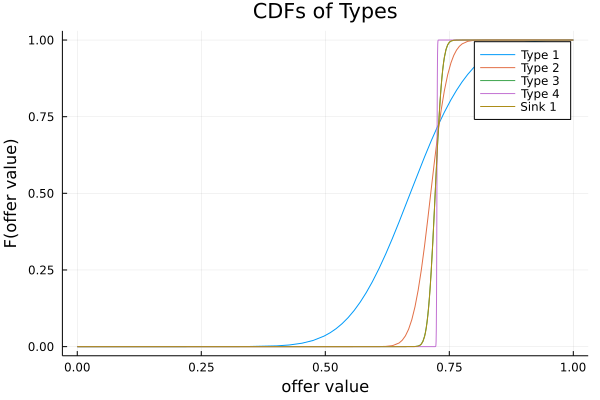

In [38]:
# https://github.com/JuliaPlots/StatsPlots.jl/blob/master/README.md
# https://docs.juliaplots.org/latest/tutorial/

select_type = 1
cdfs = plot(TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = cdf, title = "CDFs of Types", label = "Type 1")
for select_type in 2:NUMBER_OF_TYPES # academic types
    plot!(cdfs, TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = cdf, label = string("Type ", select_type))
end

for select_type in NUMBER_OF_TYPES+1:TOTAL_DISTRIBUTIONS # sinks
    plot!(cdfs, TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = cdf, label = string("Sink ", select_type - NUMBER_OF_TYPES))
end
xlabel!(cdfs, "offer value")
ylabel!(cdfs, "F(offer value)")
cdfs

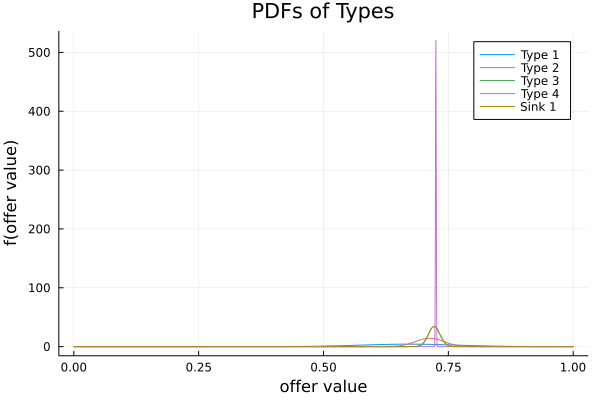

In [39]:
select_type = 1
pdfs = plot(TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = pdf, title = "PDFs of Types", label = "Type 1")
for select_type in 2:NUMBER_OF_TYPES # academic types
    plot!(pdfs, TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = pdf, label = string("Type ", select_type))
end

for select_type in NUMBER_OF_TYPES+1:TOTAL_DISTRIBUTIONS # sinks
    plot!(pdfs, TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = pdf, label = string("Sink ", select_type - NUMBER_OF_TYPES))
end
xlabel!(pdfs, "offer value")
ylabel!(pdfs, "f(offer value)")
pdfs

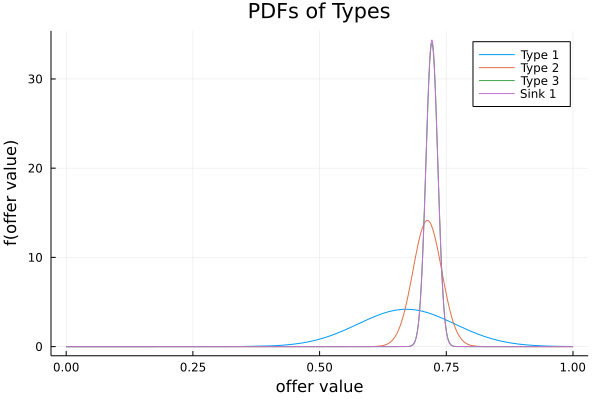

In [41]:
TYPE_TO_DELETE = 4 # change this if you want to remove the pdf of a different academic type; set to zero to not delete any
SINK_TO_DELETE = 0 # change this if you want to remove the pdf of a different sink type

select_type = 1
pdfs = plot(TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = pdf, title = "PDFs of Types", label = "Type 1")
for select_type in 2:NUMBER_OF_TYPES # academic types
    if select_type != TYPE_TO_DELETE
        plot!(pdfs, TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = pdf, label = string("Type ", select_type))
    end
end

for select_type in NUMBER_OF_TYPES+1:TOTAL_DISTRIBUTIONS # sinks
    if select_type != SINK_TO_DELETE + NUMBER_OF_TYPES
        plot!(pdfs, TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = pdf, label = string("Sink ", select_type - NUMBER_OF_TYPES))
    end
end
xlabel!(pdfs, "offer value")
ylabel!(pdfs, "f(offer value)")
pdfs

The actual allocation of departments to types is:

In [42]:
for j in 1:NUMBER_OF_TYPES
    println("TYPE ", j)
    println()
    i = 1
    for entry in est_alloc
        if entry == indices_of_greatest_elements[j]
            println(institutions[i])
        end
        i += 1
    end
    println()
    println()
end

TYPE 1

Columbia University
University of Pennsylvania
University of Wisconsin, Madison
Boston University
New York University
Boston College
University of Virginia
Cornell University
University of Southern California
University of Washington
Northwestern University
Ohio State University
University of California, Berkeley
London School of Economics and Political Science
University of Minnesota, Twin Cities
University of Oxford
Harvard University
Michigan State University
University of California Los Angeles (UCLA)
Yale University
Bocconi University (Università Bocconi)
Brown University
Stanford University
Texas A&M University, College Station
Pennsylvania State University
University of Toronto
University of Michigan
George Washington University
Duke University
University of Maryland
Princeton University
University of Chicago


TYPE 2

Eastern Kentucky University
Massachusetts Institute of Technology
University of Rochester
Vrije Universiteit Amsterdam
Syracuse University
University of A

In [45]:
for j in NUMBER_OF_TYPES+1:NUMBER_OF_SINKS+NUMBER_OF_TYPES
    println("SINK ", j - NUMBER_OF_TYPES)
    println()
    i = 1
    for entry in est_alloc
        if entry == j
            println(institutions[i])
        end
        i += 1
    end
    println()
    println()
end

SINK 1

De Nederlandsche Bank (academic sink)
Institute of Economics (Ekonomski institut), Zagreb (academic sink)
Texas A&M University, College Station (academic sink)
University of Oxford (academic sink)
Centre d'Etudes Prospectives et d'Informations Internationales (CEPII) (academic sink)
University of Sussex (academic sink)
Georgia State University (academic sink)
University of California, San Diego (academic sink)
Lund University (Lunds Universitet) (academic sink)
Centre for Advanced Financial Research And Learning (academic sink)
Dublin City University (academic sink)
Université Paris-Dauphine (academic sink)
Ruhr University Bochum (Ruhr-Universität Bochum) (academic sink)
University of North Carolina, Greensboro (academic sink)
WZB Berlin Social Science Center (Wissenschaftszentrum Berlin für Sozialforschung) (academic sink)
Ohio State University (academic sink)
Florida International University (academic sink)
INSEAD (academic sink)
Boise State University (academic sink)
Duke Un